# Installing required libraries

In [13]:
!pip install diffusers

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


# Importing Necessary libraries and modules

In [14]:
import numpy as np # linear algebra
import pandas as pd
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import textwrap
from diffusers import StableDiffusionPipeline
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from transformers import CLIPTextModel, CLIPTokenizer, CLIPProcessor, CLIPModel

# Defining input and output paths

In [15]:
input_dir = "/kaggle/input"
output_dir = "/kaggle/working"
dataset_path = "/kaggle/input/flickr8k"
clip_model_path = "/kaggle/input/custom-clip-model/fine_tuned_clip"
clip_model_processor = "/kaggle/input/custom-clip-model/fine_tuned_clip_processor"

image_dir = os.path.join(dataset_path, 'Images')
captions_file = os.path.join(dataset_path, 'captions.txt')

# Defining custom dataset class and data preprocessing

In [16]:
# Custom Dataset class for Flickr8k
class Flickr8kDataset(Dataset):
    def __init__(self, images_dir, captions_df, transform=None):
        self.images_dir = images_dir
        self.captions_df = captions_df
        self.transform = transform

    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, idx):
        image_name = self.captions_df.iloc[idx, 0]
        caption = self.captions_df.iloc[idx, 1]

        # Load image
        image_path = os.path.join(self.images_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return {"image": image, "caption": caption}

height = 224
width = 224
batch_size = 8
shuffle = True

# Define transforms for images
transform = transforms.Compose([
    transforms.Resize((height, width)),# Resizing for uniformity
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),#Normalize pixel values
])

# Load captions
captions_df = pd.read_csv(captions_file)

# Create dataset and DataLoader
dataset = Flickr8kDataset(images_dir=image_dir, captions_df=captions_df, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Defining method for training and saving CLIP model

In [17]:
def train_clip_model(base_model_name, processor_name, dataloader, device, model_save_dir, processor_save_dir, learning_rate=1e-5, epochs=5):
    """
    Trains a CLIP model using the provided dataset and saves the fine-tuned model and processor in separate directories.

    Parameters:
        base_model_name (str): Name of the base CLIP model to load.
        processor_name (str): Name of the processor for preprocessing.
        dataloader (DataLoader): DataLoader containing the training dataset.
        device (str): Compute device ('cuda' or 'cpu').
        model_save_dir (str): Directory to save the fine-tuned model.
        processor_save_dir (str): Directory to save the fine-tuned processor.
        learning_rate (float): Learning rate for the optimizer. Default is 1e-5.
        epochs (int): Number of training epochs. Default is 5.
    """
    # Initialize the base model and processor
    clip_model = CLIPModel.from_pretrained(base_model_name).to(device)
    clip_processor = CLIPProcessor.from_pretrained(processor_name)

    # Set up optimizer
    clip_optimizer = torch.optim.AdamW(clip_model.parameters(), lr=learning_rate)

    # Training loop
    clip_model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0
        with tqdm(total=len(dataloader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as progress_bar:
            for batch_index, batch_data in enumerate(dataloader):
                images = batch_data["image"].to(device)
                captions = batch_data["caption"]

                # Preprocess text inputs
                text_inputs = clip_processor(text=captions, return_tensors="pt", padding=True).to(device)

                # Forward pass
                model_outputs = clip_model(
                    pixel_values=images,
                    input_ids=text_inputs.input_ids,
                    attention_mask=text_inputs.attention_mask,
                    return_loss=True
                )
                loss = model_outputs.loss

                # Backward pass and optimization
                clip_optimizer.zero_grad()
                loss.backward()
                clip_optimizer.step()

                # Update progress bar and metrics
                total_loss += loss.item()
                progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})
                progress_bar.update(1)

        average_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch + 1} Average Loss: {average_loss:.4f}")

    # Save the fine-tuned model in the specified directory
    print(f"Saving model to: {model_save_dir}")
    clip_model.save_pretrained(model_save_dir)

    # Save the fine-tuned processor in the specified directory
    print(f"Saving processor to: {processor_save_dir}")
    clip_processor.save_pretrained(processor_save_dir)


# Initializing or Training the CLIP model

In [18]:
# Initialize CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"

if os.path.exists(clip_model_path):
    print("Fine-tuned model found. Loading...")
    model = CLIPModel.from_pretrained(clip_model_path).to(device)
    processor = CLIPProcessor.from_pretrained(clip_model_processor)
else:
    print("Fine-tuned model not found. Starting training...")
    
    train_clip_model(
    base_model_name="openai/clip-vit-large-patch14",
    processor_name="openai/clip-vit-large-patch14",
    dataloader=dataloader,
    device="cuda",
    model_save_dir="./fine_tuned_clip_model",
    processor_save_dir="./fine_tuned_clip_processor",
    learning_rate=1e-5,
    epochs=5
    )    

Fine-tuned model found. Loading...


In [19]:
model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

# Loading pre-trained VAE, UNet and Scheduler

In [20]:
# Load pre-trained VAE and U-Net
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to(device)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to(device)

In [21]:
# Define diffusion scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

In [22]:
# Load fine-tuned CLIP model
clip_model = CLIPTextModel.from_pretrained(clip_model_path).to(device)
tokenizer = CLIPTokenizer.from_pretrained(clip_model_processor)

# Defining function to generate images using all above components

In [27]:
def generate_images(
    vae, unet, encoder, tokenizer, scheduler, 
    prompts, 
    height=224, width=224, 
    device="cuda", 
    scale=7.5, seed=100, steps=70, dim=512, save_intermediate=True
):

    # Encode text prompts into embeddings
    def encode_text(prompts, max_len=None):
        if max_len is None:
            max_len = tokenizer.model_max_length
        tokens = tokenizer(prompts, padding="max_length", max_length=max_len, truncation=True, return_tensors="pt") 
        return encoder(tokens.input_ids.to(device))[0].half()

    # Decode latents into PIL images
    def latents_to_images(latents):
        latents = (1 / 0.18215) * latents
        with torch.no_grad():
            decoded = vae.decode(latents).sample
        decoded = (decoded / 2 + 0.5).clamp(0, 1)
        decoded = decoded.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (decoded * 255).round().astype("uint8")
        return [Image.fromarray(img) for img in images]

    # Initialize embeddings for prompts and unconditional text
    batch_size = len(prompts)
    text_emb = encode_text(prompts)
    empty_emb = encode_text([""] * batch_size, text_emb.shape[1])
    combined_emb = torch.cat([empty_emb, text_emb])

    # Set random seed for reproducibility
    if seed:
        torch.manual_seed(seed)
    
    # Initialize latent variables and scheduler
    latents = torch.randn((batch_size, unet.config.in_channels, dim // 8, dim // 8))
    scheduler.set_timesteps(steps)
    latents = latents.to(device).half() * scheduler.init_noise_sigma

    # Perform denoising steps
    for step, ts in enumerate(tqdm(scheduler.timesteps)):
        inputs = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad():
            uncond, cond = unet(inputs, ts, encoder_hidden_states=combined_emb).sample.chunk(2)
        pred = uncond + scale * (cond - uncond)
        latents = scheduler.step(pred, ts, latents).prev_sample

    return latents_to_images(latents)


def display_images(images, prompts):
    count = len(images)
    grid_size = math.ceil(math.sqrt(count))
    rows = (count + grid_size - 1) // grid_size

    fig, axes = plt.subplots(rows, grid_size, figsize=(grid_size * 3, rows * 3))
    axes = np.array(axes).reshape(-1)

    for i in range(rows * grid_size):
        if i < count:
            axes[i].imshow(images[i])
            axes[i].title.set_text(prompts[i] if prompts[i] else "<No Text>")
            axes[i].axis("off")
        else:
            axes[i].axis("off")

    plt.subplots_adjust(hspace=0.5)
    plt.show()



100%|██████████| 70/70 [00:18<00:00,  3.81it/s]


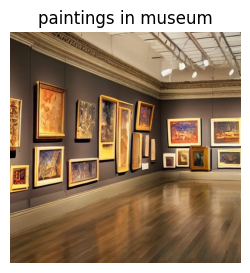

In [43]:
prompt1=["paintings in museum"]
images = generate_images(
    vae, unet, clip_model, tokenizer, scheduler, 
    prompt1
)

display_images(images, prompt1)

100%|██████████| 70/70 [01:02<00:00,  1.12it/s]


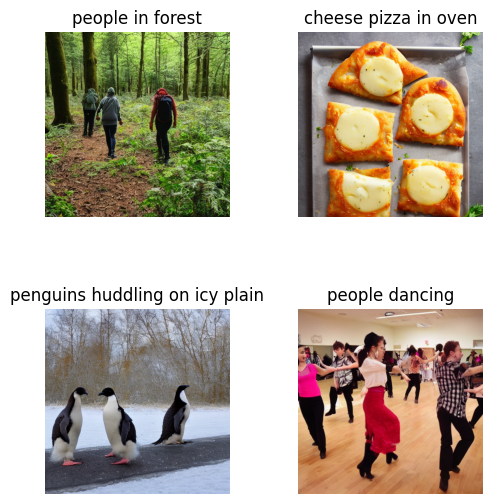

In [45]:
prompts=["people in forest","cheese pizza in oven","penguins huddling on icy plain","people dancing"] 

images = generate_images(
    vae, unet, clip_model, tokenizer, scheduler, 
    prompts
)

display_images(images, prompts)

 ## Without fine-tuning CLIP Model

100%|██████████| 70/70 [00:18<00:00,  3.81it/s]


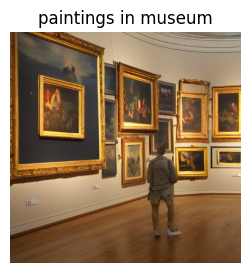

In [48]:
model1 = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
processor1 = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

prompt1=["paintings in museum"]
images = generate_images(
    vae, unet, model1, processor1, scheduler, 
    prompt1
)

display_images(images, prompt1)